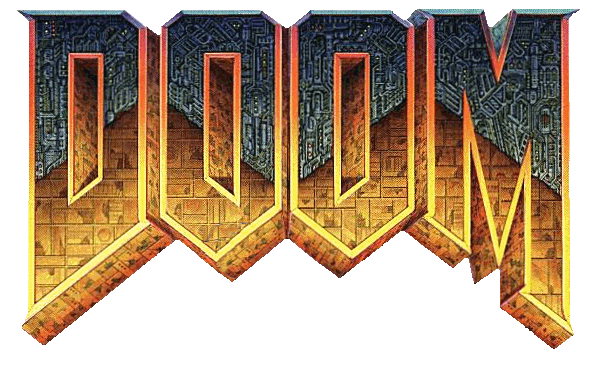

In [3]:
from IPython.display import Image
Image(filename='doomlogo.png')

In [4]:
# loading necessary packages
import numpy as np
import gym
import matplotlib.pyplot as plt
import cv2

from gdoom_env import *
from gym.utils.play import play
from collections import deque

import tensorflow as tf

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


# Setting up the gdoom environment

$\underline{Scenarios}$

* 0 - basic
* 1 - deadly_corridor
* 2 - defend_the_center
* 3 - defend_the_line
* 4 - health_gathering
* 5 - my_way_home
* 6 - predict_position
* 7 - take_cover
* 8 - deathmatch

In [5]:
env = gym.make("doom_scenario0_96-v0")
frame = env.reset()
print("Frame size for cpu player: ", np.asarray(frame).shape )

/home/wamberg/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Doom> Loading level: /home/wamberg/.local/lib/python3.6/site-packages/vizdoom/scenarios/basic.cfg
Frame size for cpu player:  (96, 96, 4)


...and the environment parameters

In [10]:
total_episodes = 5000          
max_steps = 100 # the maximum number of steps in episode              
gamma = 0.99 # discounting factor

eps_start = 1.0 # exploration probability @ the beginning
eps_stop = 0.01 # minimum exploration probability 
decay_rate = 1e-4 # decay rate for exploration probability

action_size = 3 # number of possible actions

alpha = 1e-4 # learning rate
memory_size = 1000000         
batch_size = 64               
pretrain_length = batch_size

# Some testing of the environment

The preprocesesing is done in $\verb|gdoom_env.py|$, including grayscaling and resizing (84x84)

In [7]:
# Function for further adjusting and cropping the image
def crop(state):
    state = np.asarray(state)
    crop = state[30:-10,10:-20] # crop screen ie remove roof
    norm_img = crop/255.0 # normalize
    
    return cv2.resize(norm_img, img_size) # return resized image

-4.0 False


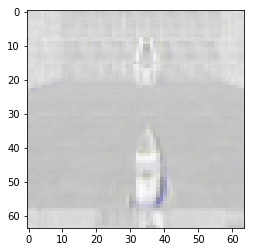

In [8]:
env.step(1)
observation, reward, done, info = env.step(1)
print(reward, done)

img_size = (64, 64)

plt.imshow(crop(observation),interpolation='none')

new_frame = crop(observation)
state_size_tuple = np.asarray(new_frame).shape
state_size = list(state_size_tuple)

In [9]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()
        
print(rewards[-10:])

[-4.0, -4.0, -4.0, -9.1, -4.0, -4.0, -4.0, -9.1, -4.0, -4.0]


# Neural Network

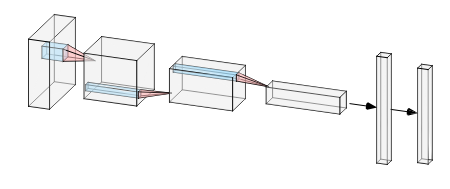

In [12]:
Image(filename='neural_deepq.png')

| Layer | Input | Filter size | Stride | Output |
| --- | --- | --- | --- |--- |
| conv1 | 84x84x4 | 8x8 | 4 | 20x20x32 |
| conv2 | 20x20x32 | 4x4 | 2 | 9x9x64 |
| conv3 | 9x9x64 | 3x3 | 2 | 3x3x128 |
| flatten | 3x3x128 | -  | - | 1152 |
| fc | 1152 | - | - | 512 |

In [8]:
class DQNN:
    def __init__(self, state_size, action_size, alpha, name='DQNN'): 
        # the state inupts
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs_")
                       
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                        training = True,
                                        epsilon = 1e-5,
                                        name = 'batch_norm1')
            
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
        
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
        
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")            
            
            self.flatten = tf.layers.flatten(self.conv3_out)            
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  name="fc1")
            
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        units = 3, 
                                        activation=None)
            
            ### Train with loss (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.opt = tf.train.RMSPropOptimizer(self.alpha).minimize(self.loss)

In [9]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [10]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNN(state_size, action_size, alpha)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [11]:
env.reset() # initialize

state, reward, done, _ = env.step(env.action_space.sample()) # take a step based on a sample from the action space
state = crop(state) # preproces images

memory = Memory(max_size=memory_size)

for i in range(pretrain_length):
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    next_state = crop(next_state)
    
    if done: # ending episode
        next_state = np.zeros(state_size_tuple)
        
        memory.add((state, action, reward, next_state, done)) # add the experience to the memory
        
        env.reset() # beging new episode   
        state, reward, done, _ = env.step(env.action_space.sample())
        state = crop(state)
    
    else:
        memory.add((state, action, reward, next_state, done))
        state = next_state
        state = crop(state)

Training with experiences

In [14]:
saver = tf.train.Saver()

rewards_list = []
alive_list = []
kill_list = []
frame_count = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    for episode in range(1, total_episodes):
        total_reward = 0
        t = 0
        
        while t < max_steps:
            step += 1
                       
            # greedy or exploration move
            explore_p = eps_stop + (eps_start - eps_stop)*np.exp(-decay_rate*step)
            
            if explore_p > np.random.rand(): # exploration move
                action = env.action_space.sample() 

            else: # greedy move
                feed = {DQNetwork.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(DQNetwork.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            next_state, reward, done, info = env.step(action)
            next_state = crop(next_state)
            total_reward += reward
            
            if done:
                # episode ends, no next state
                alive = info["time_alive"]
                kills = info["kills"]
                frame_count.append(alive)
                
                print(kills)
                
                alive_list.append(alive)
                kill_list.append(kills)
                
                next_state = np.zeros(state.shape)
                t = max_steps
                
                
                print('Episode: {}'.format(episode),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                     )
                print('Time alive: {:4f}'.format(np.mean(alive_list[-50:])),
                     'Kills: {:4f}'.format(np.mean(kill_list[-50:])),
                     'Frame count: {:.4f}'.format(np.sum(frame_count)))
                
                rewards_list.append((episode, total_reward))
            
                memory.add((state, action, reward, next_state,done))
                
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
                state = crop(state)
                
            else:
                memory.add((state, action, reward, next_state, done))
                state = next_state
                state = crop(state)
                t += 1 
                
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch], ndmin = 3)
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch], ndmin = 3)

            dones = np.array([each[4] for each in batch])      
            
            target_Q_batch = []
            
            # Train the network, get Q values for next state
            Q_next_state = sess.run(DQNetwork.output, feed_dict={DQNetwork.inputs_: next_states})
            
            # Set target_Q = r if episode ends at s+1, otherwise = r+gamma*maxQ(s',a')
            for i in range(len(batch)):
                terminal = dones[i]
                
                if terminal:
                    target_Q_batch.append(rewards[i])
                    
                else:
                    target = rewards[i] + gamma * np.max(Q_next_state[i])
                    target_Q_batch.append(target)
                    
            target_batch = np.array([each for each in target_Q_batch])

            loss, _ = sess.run([DQNetwork.loss, DQNetwork.opt],
                                    feed_dict={DQNetwork.inputs_: states,
                                               DQNetwork.target_Q: target_batch,
                                               DQNetwork.actions_: actions})
                 
       
        # Save model every 5 episodes
        if episode % 5 == 0:
            save_path = saver.save(sess, "./models/model.ckpt")
            print("Model Saved")

1.0
Episode: 1 Total reward: -143.89999999999995 Training loss: 167.4497 Explore P: 0.9949
Time alive: 52.000000 Kills: 1.000000 Frame count: 52.0000
0.0
Episode: 2 Total reward: -302.3 Training loss: 181.9414 Explore P: 0.9891
Time alive: 55.500000 Kills: 0.500000 Frame count: 111.0000
1.0
Episode: 3 Total reward: 92.9 Training loss: 636.1024 Explore P: 0.9888
Time alive: 38.000000 Kills: 0.666667 Frame count: 114.0000
1.0
Episode: 4 Total reward: 71.80000000000001 Training loss: 172.0680 Explore P: 0.9881
Time alive: 30.250000 Kills: 0.750000 Frame count: 121.0000
0.0
Episode: 5 Total reward: -292.09999999999997 Training loss: 18.6626 Explore P: 0.9823
Time alive: 36.000000 Kills: 0.600000 Frame count: 180.0000
Model Saved
0.0
Episode: 6 Total reward: 59.9 Training loss: 180.3943 Explore P: 0.9815
Time alive: 31.500000 Kills: 0.500000 Frame count: 189.0000
1.0
Episode: 7 Total reward: -1.0 Training loss: 15.5910 Explore P: 0.9814
Time alive: 27.142857 Kills: 0.571429 Frame count: 190

0.0
Episode: 58 Total reward: -30.5 Training loss: 31.3940 Explore P: 0.8167
Time alive: 36.200000 Kills: 0.380000 Frame count: 2048.0000
1.0
Episode: 59 Total reward: -1.0 Training loss: 198.1923 Explore P: 0.8166
Time alive: 35.100000 Kills: 0.380000 Frame count: 2049.0000
0.0
Episode: 60 Total reward: -302.29999999999995 Training loss: 703.9767 Explore P: 0.8118
Time alive: 35.860000 Kills: 0.360000 Frame count: 2108.0000
Model Saved
1.0
Episode: 61 Total reward: -25.299999999999997 Training loss: 191.7249 Explore P: 0.8094
Time alive: 36.400000 Kills: 0.380000 Frame count: 2138.0000
1.0
Episode: 62 Total reward: 80.9 Training loss: 367.9233 Explore P: 0.8090
Time alive: 35.340000 Kills: 0.400000 Frame count: 2144.0000
0.0
Episode: 63 Total reward: -110.89999999999998 Training loss: 191.6082 Explore P: 0.8056
Time alive: 35.000000 Kills: 0.400000 Frame count: 2186.0000
0.0
Episode: 64 Total reward: -292.09999999999997 Training loss: 190.5835 Explore P: 0.8009
Time alive: 35.000000 K

0.0
Episode: 114 Total reward: -307.6 Training loss: 301.9528 Explore P: 0.6730
Time alive: 35.280000 Kills: 0.420000 Frame count: 4009.0000
1.0
Episode: 115 Total reward: 58.7 Training loss: 152.9601 Explore P: 0.6724
Time alive: 34.280000 Kills: 0.440000 Frame count: 4018.0000
Model Saved
0.0
Episode: 116 Total reward: -292.1 Training loss: 135.7442 Explore P: 0.6685
Time alive: 34.280000 Kills: 0.440000 Frame count: 4077.0000
0.0
Episode: 117 Total reward: -256.4 Training loss: 152.4064 Explore P: 0.6647
Time alive: 35.420000 Kills: 0.420000 Frame count: 4136.0000
1.0
Episode: 118 Total reward: -1.0 Training loss: 227.1411 Explore P: 0.6646
Time alive: 34.260000 Kills: 0.440000 Frame count: 4137.0000
0.0
Episode: 119 Total reward: -168.7 Training loss: 142.6330 Explore P: 0.6607
Time alive: 34.680000 Kills: 0.440000 Frame count: 4196.0000
1.0
Episode: 120 Total reward: 51.800000000000004 Training loss: 507.7792 Explore P: 0.6600
Time alive: 33.920000 Kills: 0.440000 Frame count: 420

1.0
Episode: 171 Total reward: -9.299999999999983 Training loss: 379.2152 Explore P: 0.5461
Time alive: 37.320000 Kills: 0.320000 Frame count: 6133.0000
1.0
Episode: 172 Total reward: 25.599999999999994 Training loss: 726.4543 Explore P: 0.5453
Time alive: 36.460000 Kills: 0.340000 Frame count: 6149.0000
0.0
Episode: 173 Total reward: -281.9 Training loss: 238.6859 Explore P: 0.5421
Time alive: 36.460000 Kills: 0.340000 Frame count: 6208.0000
0.0
Episode: 174 Total reward: -276.79999999999995 Training loss: 191.7473 Explore P: 0.5390
Time alive: 36.460000 Kills: 0.340000 Frame count: 6267.0000
0.0
Episode: 175 Total reward: -281.79999999999995 Training loss: 76.9781 Explore P: 0.5359
Time alive: 37.600000 Kills: 0.320000 Frame count: 6326.0000
Model Saved
0.0
Episode: 176 Total reward: 79.9 Training loss: 72.4874 Explore P: 0.5357
Time alive: 37.280000 Kills: 0.300000 Frame count: 6330.0000
1.0
Episode: 177 Total reward: 67.80000000000001 Training loss: 426.0751 Explore P: 0.5353
Time 

0.0
Episode: 227 Total reward: -292.09999999999997 Training loss: 256.8930 Explore P: 0.4438
Time alive: 38.260000 Kills: 0.320000 Frame count: 8251.0000
1.0
Episode: 228 Total reward: 12.900000000000006 Training loss: 323.8782 Explore P: 0.4428
Time alive: 38.280000 Kills: 0.320000 Frame count: 8274.0000
0.0
Episode: 229 Total reward: -261.5 Training loss: 185.1576 Explore P: 0.4403
Time alive: 39.260000 Kills: 0.300000 Frame count: 8333.0000
0.0
Episode: 230 Total reward: -261.5 Training loss: 506.9716 Explore P: 0.4377
Time alive: 40.120000 Kills: 0.300000 Frame count: 8392.0000
Model Saved
1.0
Episode: 231 Total reward: 96.9 Training loss: 262.9290 Explore P: 0.4376
Time alive: 38.980000 Kills: 0.320000 Frame count: 8394.0000
0.0
Episode: 232 Total reward: -266.59999999999997 Training loss: 461.6002 Explore P: 0.4351
Time alive: 40.140000 Kills: 0.300000 Frame count: 8453.0000
0.0
Episode: 233 Total reward: -292.1 Training loss: 481.9081 Explore P: 0.4326
Time alive: 40.140000 Kill

1.0
Episode: 283 Total reward: 80.9 Training loss: 421.0922 Explore P: 0.3605
Time alive: 37.440000 Kills: 0.360000 Frame count: 10384.0000
1.0
Episode: 284 Total reward: 96.9 Training loss: 991.5540 Explore P: 0.3604
Time alive: 37.360000 Kills: 0.360000 Frame count: 10386.0000
1.0
Episode: 285 Total reward: 96.9 Training loss: 588.2557 Explore P: 0.3603
Time alive: 36.220000 Kills: 0.380000 Frame count: 10388.0000
Model Saved
0.0
Episode: 286 Total reward: -312.6 Training loss: 657.2024 Explore P: 0.3583
Time alive: 36.220000 Kills: 0.380000 Frame count: 10447.0000
1.0
Episode: 287 Total reward: 96.9 Training loss: 256.3148 Explore P: 0.3582
Time alive: 36.120000 Kills: 0.380000 Frame count: 10449.0000
0.0
Episode: 288 Total reward: -323.0 Training loss: 365.3973 Explore P: 0.3562
Time alive: 36.120000 Kills: 0.380000 Frame count: 10508.0000
0.0
Episode: 289 Total reward: 63.8 Training loss: 384.7285 Explore P: 0.3559
Time alive: 35.080000 Kills: 0.380000 Frame count: 10515.0000
0.0


1.0
Episode: 339 Total reward: -98.89999999999995 Training loss: 407.2501 Explore P: 0.2967
Time alive: 37.580000 Kills: 0.320000 Frame count: 12394.0000
1.0
Episode: 340 Total reward: 17.599999999999994 Training loss: 385.2983 Explore P: 0.2961
Time alive: 36.760000 Kills: 0.340000 Frame count: 12412.0000
Model Saved
0.0
Episode: 341 Total reward: -282.09999999999997 Training loss: 291.1526 Explore P: 0.2945
Time alive: 36.760000 Kills: 0.340000 Frame count: 12471.0000
0.0
Episode: 342 Total reward: -276.7 Training loss: 364.4989 Explore P: 0.2928
Time alive: 37.840000 Kills: 0.340000 Frame count: 12530.0000
0.0
Episode: 343 Total reward: -266.59999999999997 Training loss: 435.1271 Explore P: 0.2911
Time alive: 37.840000 Kills: 0.340000 Frame count: 12589.0000
0.0
Episode: 344 Total reward: -30.299999999999997 Training loss: 353.0885 Explore P: 0.2903
Time alive: 38.200000 Kills: 0.320000 Frame count: 12618.0000
0.0
Episode: 345 Total reward: -276.79999999999995 Training loss: 235.886

1.0
Episode: 394 Total reward: 13.599999999999994 Training loss: 327.2797 Explore P: 0.2374
Time alive: 41.820000 Kills: 0.420000 Frame count: 14709.0000
0.0
Episode: 395 Total reward: -271.7 Training loss: 293.3477 Explore P: 0.2361
Time alive: 41.820000 Kills: 0.420000 Frame count: 14768.0000
Model Saved
0.0
Episode: 396 Total reward: -271.7 Training loss: 357.5622 Explore P: 0.2348
Time alive: 42.180000 Kills: 0.400000 Frame count: 14827.0000
0.0
Episode: 397 Total reward: -276.79999999999995 Training loss: 353.7025 Explore P: 0.2334
Time alive: 43.220000 Kills: 0.380000 Frame count: 14886.0000
0.0
Episode: 398 Total reward: -246.2 Training loss: 161.8505 Explore P: 0.2321
Time alive: 44.140000 Kills: 0.360000 Frame count: 14945.0000
0.0
Episode: 399 Total reward: -281.9 Training loss: 253.5210 Explore P: 0.2308
Time alive: 45.300000 Kills: 0.340000 Frame count: 15004.0000
1.0
Episode: 400 Total reward: 52.900000000000006 Training loss: 472.4724 Explore P: 0.2305
Time alive: 44.3800

0.0
Episode: 449 Total reward: -266.59999999999997 Training loss: 506.3095 Explore P: 0.1927
Time alive: 37.920000 Kills: 0.400000 Frame count: 16900.0000
0.0
Episode: 450 Total reward: 47.8 Training loss: 509.5214 Explore P: 0.1925
Time alive: 37.880000 Kills: 0.380000 Frame count: 16911.0000
Model Saved
1.0
Episode: 451 Total reward: 88.9 Training loss: 602.0726 Explore P: 0.1924
Time alive: 37.320000 Kills: 0.380000 Frame count: 16915.0000
0.0
Episode: 452 Total reward: -261.4 Training loss: 587.0859 Explore P: 0.1913
Time alive: 38.480000 Kills: 0.360000 Frame count: 16974.0000
1.0
Episode: 453 Total reward: -1.0 Training loss: 511.3801 Explore P: 0.1913
Time alive: 38.340000 Kills: 0.360000 Frame count: 16975.0000
1.0
Episode: 454 Total reward: -24.19999999999999 Training loss: 396.0666 Explore P: 0.1907
Time alive: 38.780000 Kills: 0.360000 Frame count: 17006.0000
0.0
Episode: 455 Total reward: -276.79999999999995 Training loss: 501.3931 Explore P: 0.1897
Time alive: 39.920000 Ki

0.0
Episode: 504 Total reward: -307.6 Training loss: 858.6031 Explore P: 0.1607
Time alive: 36.340000 Kills: 0.340000 Frame count: 18823.0000
0.0
Episode: 505 Total reward: -18.499999999999986 Training loss: 946.9007 Explore P: 0.1604
Time alive: 35.640000 Kills: 0.340000 Frame count: 18847.0000
Model Saved
1.0
Episode: 506 Total reward: -1.0 Training loss: 1222.4030 Explore P: 0.1603
Time alive: 34.480000 Kills: 0.360000 Frame count: 18848.0000
1.0
Episode: 507 Total reward: 96.9 Training loss: 890.0323 Explore P: 0.1603
Time alive: 33.340000 Kills: 0.380000 Frame count: 18850.0000
0.0
Episode: 508 Total reward: 72.9 Training loss: 816.2260 Explore P: 0.1602
Time alive: 33.220000 Kills: 0.380000 Frame count: 18856.0000
0.0
Episode: 509 Total reward: 52.8 Training loss: 1264.7549 Explore P: 0.1601
Time alive: 33.120000 Kills: 0.360000 Frame count: 18866.0000
1.0
Episode: 510 Total reward: -98.89999999999998 Training loss: 1178.5450 Explore P: 0.1594
Time alive: 33.880000 Kills: 0.36000

0.0
Episode: 560 Total reward: -241.1 Training loss: 937.5598 Explore P: 0.1391
Time alive: 29.280000 Kills: 0.440000 Frame count: 20372.0000
Model Saved
1.0
Episode: 561 Total reward: 76.9 Training loss: 1139.8114 Explore P: 0.1390
Time alive: 29.180000 Kills: 0.460000 Frame count: 20379.0000
0.0
Episode: 562 Total reward: -261.5 Training loss: 1207.0551 Explore P: 0.1382
Time alive: 29.180000 Kills: 0.460000 Frame count: 20438.0000
1.0
Episode: 563 Total reward: 96.9 Training loss: 1298.6550 Explore P: 0.1382
Time alive: 28.040000 Kills: 0.480000 Frame count: 20440.0000
0.0
Episode: 564 Total reward: -251.29999999999998 Training loss: 1337.3988 Explore P: 0.1375
Time alive: 28.340000 Kills: 0.460000 Frame count: 20499.0000
0.0
Episode: 565 Total reward: -266.69999999999993 Training loss: 1511.5193 Explore P: 0.1367
Time alive: 28.340000 Kills: 0.460000 Frame count: 20558.0000
Model Saved
1.0
Episode: 566 Total reward: 96.9 Training loss: 1777.8538 Explore P: 0.1367
Time alive: 27.200

1.0
Episode: 616 Total reward: -40.599999999999994 Training loss: 1875.9692 Explore P: 0.1189
Time alive: 30.220000 Kills: 0.420000 Frame count: 22071.0000
1.0
Episode: 617 Total reward: 96.9 Training loss: 1358.2280 Explore P: 0.1189
Time alive: 29.080000 Kills: 0.440000 Frame count: 22073.0000
1.0
Episode: 618 Total reward: 96.9 Training loss: 1417.2595 Explore P: 0.1189
Time alive: 27.940000 Kills: 0.460000 Frame count: 22075.0000
1.0
Episode: 619 Total reward: -31.5 Training loss: 1577.8330 Explore P: 0.1186
Time alive: 28.480000 Kills: 0.460000 Frame count: 22104.0000
0.0
Episode: 620 Total reward: -266.7 Training loss: 1596.9934 Explore P: 0.1179
Time alive: 29.360000 Kills: 0.440000 Frame count: 22163.0000
Model Saved
0.0
Episode: 621 Total reward: -302.59999999999997 Training loss: 1661.8304 Explore P: 0.1173
Time alive: 29.360000 Kills: 0.440000 Frame count: 22222.0000
1.0
Episode: 622 Total reward: 60.900000000000006 Training loss: 2239.8442 Explore P: 0.1172
Time alive: 28.6

0.0
Episode: 671 Total reward: -261.5 Training loss: 1818.1886 Explore P: 0.1037
Time alive: 27.040000 Kills: 0.300000 Frame count: 23574.0000
0.0
Episode: 672 Total reward: -69.4 Training loss: 1809.6761 Explore P: 0.1036
Time alive: 27.080000 Kills: 0.280000 Frame count: 23587.0000
0.0
Episode: 673 Total reward: -323.0 Training loss: 1069.8484 Explore P: 0.1030
Time alive: 27.080000 Kills: 0.280000 Frame count: 23646.0000
0.0
Episode: 674 Total reward: -69.4 Training loss: 1799.0461 Explore P: 0.1029
Time alive: 26.160000 Kills: 0.280000 Frame count: 23659.0000
0.0
Episode: 675 Total reward: 79.9 Training loss: 3234.6245 Explore P: 0.1029
Time alive: 25.060000 Kills: 0.280000 Frame count: 23663.0000
Model Saved
0.0
Episode: 676 Total reward: 47.699999999999996 Training loss: 1818.5208 Explore P: 0.1028
Time alive: 24.080000 Kills: 0.280000 Frame count: 23673.0000
1.0
Episode: 677 Total reward: 88.9 Training loss: 2428.1838 Explore P: 0.1028
Time alive: 24.120000 Kills: 0.280000 Frame

KeyboardInterrupt: 

Reward plotting

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0, 0.5, 'Total Reward')

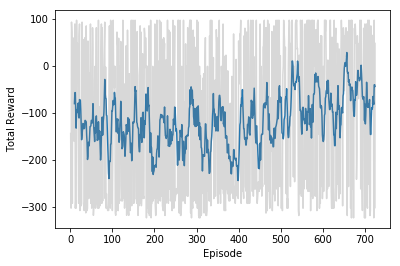

In [16]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')